<a href="https://colab.research.google.com/github/yusufakcakaya/Algorythm-NLP-Entity-Recognition/blob/Nichelle/Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here , we have implemented a knowledge graph from a WikiPedia actors dataset.
The article by [1] becominghuman.ai and [2] analyticsvidya and has been heavily referred for this. But we have made improvements in the form of :
1. Separating a text into sentences using spacy's sentencizer.
2. Saving it into a dataframe.
1. Data Preprocessing - Removed punctuations , stop words
2. Named Entity Recognition - This has helped in constructing a more meaningful graph with less noise.


In [157]:
import re
import pandas as pd
import spacy
from tqdm import tqdm
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string 
tqdm._instances.clear()

In [152]:
#  text = 'The implementation of the French "pass sanitaire" (health pass) in the summer of 2021 is estimated to have saved nearly 4,000 lives in France, shows a recent study by the Conseil d’analyse économique (CAE). Health passes and vaccination certificates remain the subject of discussion (in Belgium too), but independent scientists from various universities and institutes found that France’s sudden implementation of the pass not only saved thousands of lives but also saved €6 billion for the country’s economy.After France had already imposed strict measures (such as a 18:00 curfew), it was among the first European countries to require its ‘pass sanitaire’ to gain access to bars and restaurants. From August, it became mandatory for large shopping centres, cultural venues and long bus and train journeys. Immediately after French President Emmanuel Macron announced on 12 July 2021 that the ‘pass sanitaire’ would be made mandatory to enter bars, restaurants and museums, vaccination appointments surged as almost a million first shots were booked the next day. Now, as the country tightened its rules again by replacing its “health pass” with a “vaccination pass,” the Conseil d’analyse économique published a study, which has not yet been peer-reviewed, to show the impact of the ‘pass sanitaire,’ focused on vaccination coverage, hospitalisations and deaths due to Covid-19, as well as its economic consequences.'

In [153]:
# from spacy.lang.en import English

# nlp = English()  # just the language with no model
# sentencizer = nlp.create_pipe("sentencizer")
# nlp.add_pipe(sentencizer)
# sent = [sent.text for sent in nlp(text).sents]
# sent

['The implementation of the French "pass sanitaire" (health pass) in the summer of 2021 is estimated to have saved nearly 4,000 lives in France, shows a recent study by the Conseil d’analyse économique (CAE).',
 'Health passes and vaccination certificates remain the subject of discussion (in Belgium too), but independent scientists from various universities and institutes found that France’s sudden implementation of the pass not only saved thousands of lives but also saved €6 billion for the country’s economy.',
 'After France had already imposed strict measures (such as a 18:00 curfew), it was among the first European countries to require its ‘pass sanitaire’ to gain access to bars and restaurants.',
 'From August, it became mandatory for large shopping centres, cultural venues and long bus and train journeys.',
 'Immediately after French President Emmanuel Macron announced on 12 July 2021 that the ‘pass sanitaire’ would be made mandatory to enter bars, restaurants and museums, vaccin

In [154]:
# import pandas as pd

# df1= pd.DataFrame(columns=["sentence"])

# df1 = df1.append(
#         [{'sentence' : sent.text} for sent in nlp(text).sents],
#         ignore_index=True
#     )
# df1

,sentence
0,"The implementation of the French ""pass sanitai..."
1,Health passes and vaccination certificates rem...
2,After France had already imposed strict measur...
3,"From August, it became mandatory for large sho..."
4,Immediately after French President Emmanuel Ma...
5,"Now, as the country tightened its rules again ..."


In [155]:
# df1.to_csv('Data_1.csv')

In [156]:
# from google.colab import files
# files.download("Data_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [158]:
from google.colab import files
uploaded = files.upload()

Saving Data_1.csv to Data_1 (3).csv


In [159]:
import io
sentences = pd.read_csv(io.BytesIO(uploaded['Data_1.csv']))

In [160]:
sentences.head()

,Unnamed: 0,sentence
0,0,"The implementation of the French ""pass sanitai..."
1,1,Health passes and vaccination certificates rem...
2,2,After France had already imposed strict measur...
3,3,"From August, it became mandatory for large sho..."
4,4,Immediately after French President Emmanuel Ma...


**Entity Pairs Extraction Function**

In [184]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      # Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix

      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
          #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + tok.text

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
        prev_token_dep = ""
        prev_token_text = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]    

Now lets obtain entity pairs from a sentence

In [179]:
[ent1,ent2] = get_entity("Paul keating is an economic forecaster from Australia")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("Paul keating is from Australia")

Subj : keating, obj : economic  Australia


['keating', 'Australia']

In [180]:
entity_pairs = []
for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()
entity_pairs

100%|██████████| 6/6 [00:00<00:00, 61.28it/s]


[['implementation', 'recent  économique'],
 ['various  France', 'country  economy'],
 ['18:00  it', 'European  bars'],
 ['it', 'large  centres'],
 ['first  shots', '2021  bars'],
 ['again  which', 'due  Covid-19']]

In [181]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]
subjects
objects

['recent  économique',
 'country  economy',
 'European  bars',
 'large  centres',
 '2021  bars',
 'due  Covid-19']

**Relation** **Extraction** 

The Relation between nodes has been extracted. The hypothesis is that the main verb or the Root word forms the relation between the subject and the object.

In [182]:


def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'VB','OP':'?'},{'POS':'ADJ','OP':'?'}]
   #define the pattern 
  # pattern = [{'DEP':'ROOT'}, 
  #           {'DEP':'prep','OP':"?"},
  #           {'DEP':'agent','OP':"?"},  
  #           {'POS':'ADJ','OP':"?"},
  #            {'ENT_TYPE':'PERSON', 'OP':'?'},
  #            {'ENT_TYPE':'GPE', 'OP':'?'}] 
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  #matches = matcher(doc)

  matches = matcher(doc)
  k = len(matches)-1


  span = doc[matches[k][1]:matches[k][2]] 
  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  #span = doc[matches[0][1]:matches[0][2]]
  return span.text


Below we observe a problem. The Relation for the second should be "couldn't complete", in order to correctly capture the semantics. But it fails to do so.

In [166]:
get_entity("John completed the task"), get_relation("John completed the task")

(['John', 'task'], 'completed')

In [167]:
get_entity("John couldn't complete the task"), get_relation("John couldn't complete the task")

(['John', 'task'], 'complete')

Anyway, we move on. Let's get the relations for the entire dataset

In [168]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
relations

100%|██████████| 6/6 [00:00<00:00, 67.53it/s]


['shows', 'remain', 'was among', 'became mandatory', 'surged', 'published']

In [185]:
# extract subject
source = [i[0] for i in entity_pairs] 
# extract object
target = [i[1] for i in entity_pairs] 


kg_df = pd.DataFrame({'source':source,'target':target,'edge':relations})
kg_df

,source,target,edge
0,implementation,recent économique,shows
1,various France,country economy,remain
2,18:00 it,European bars,was among
3,it,large centres,became mandatory
4,first shots,2021 bars,surged
5,again which,due Covid-19,published


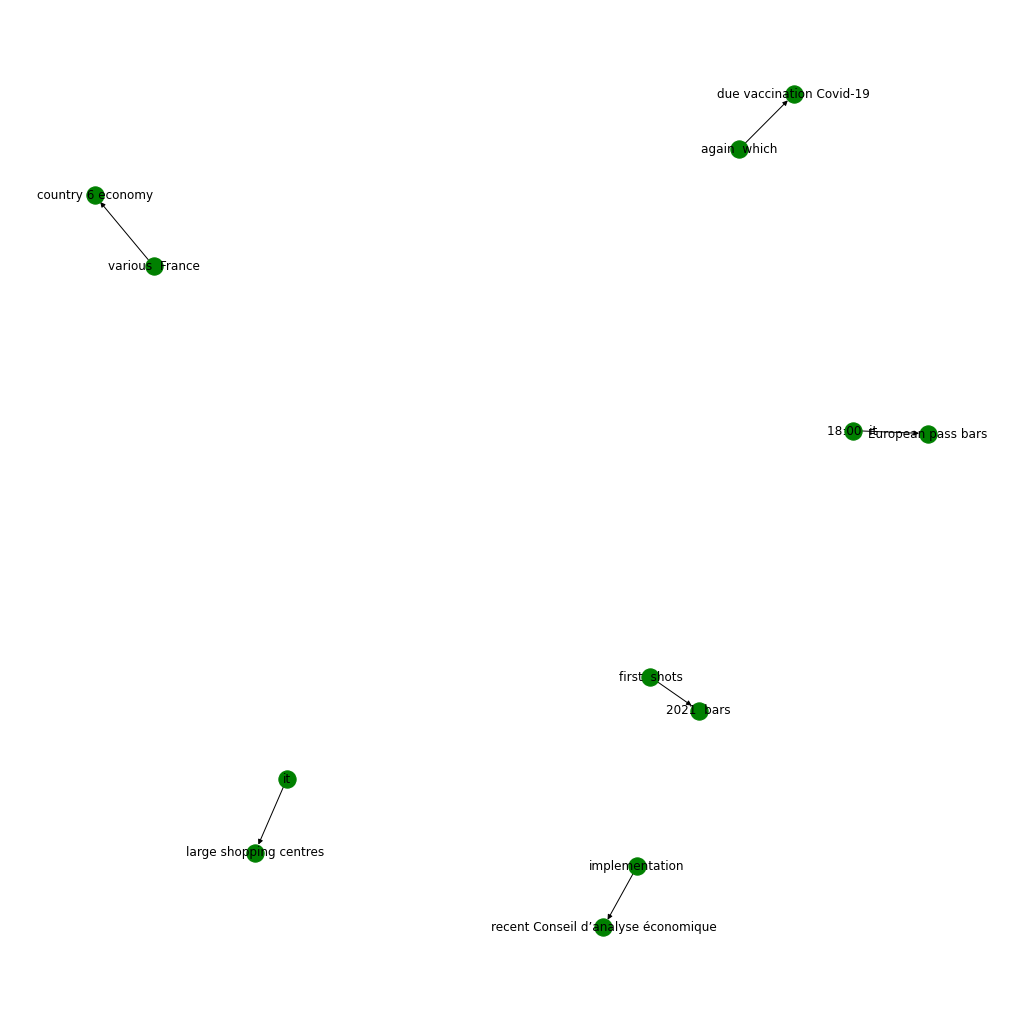

In [170]:
 
import matplotlib.pyplot as plot
# Create DG from the dataframe
graph = nx.from_pandas_edgelist(kg_df, "source", "target",
                         edge_attr=True, create_using=nx.MultiDiGraph())
# plotting the network
plot.figure(figsize=(14, 14))
posn = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

Let's look at the topmost occuring subjects 

In [81]:
pd.Series(subjects).value_counts()

We                      1
Paul Keating            1
down  country           1
annual  Keating         1
two  he                 1
Unemployment            1
Terms                   1
Second World Keating    1
dtype: int64

We observe that these words are mostly generic, hence of not much use to us.


In [82]:
pd.Series(relations).value_counts()[:10]

said                 3
is                   1
forecast economic    1
are                  1
told                 1
pushing              1
dtype: int64

Not surprisingly, "is" and "was" forms the most common relations, simply because they are the most common words. We want more meaningful subjects to be more prominent.

**Data Pre - Processing**

Let's see what happens if we pre-process the data.
We remove stopwords and punctuation marks

In [83]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [84]:
def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  #words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp

In [85]:
preprocessed_sentences = [preprocess(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
preprocessed_sentences

100%|██████████| 8/8 [00:00<00:00, 195.88it/s]


['KEATING REVISES DOWN AUSTRALIAN GROWTH FORECAST Treasurer Paul Keating forecast economic growth slightly two  financial year ending June year  2.25  forecast contained 1986  87 budget delivered last August .',
 'Australia terms trade also fell  18   past two years  told Parliament .',
 'Terms trade difference import export price indexes .',
 'Despite figures  budget forecast 1.75  annual growth employment would met  Keating said .',
 'Unemployment currently 8.2  workforce .',
 'This government dragging Australia trading holocaust kind seen since Second World War  Keating said .',
 'We pushing place recession .',
 'We holding gains unemployment  bringing unemployment  said  adding government help country avoid recession .']

Getting entity pairs from preprocessed sentences

In [86]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████| 8/8 [00:00<00:00, 91.21it/s]


In [ ]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|██████████| 7/7 [00:00<00:00, 116.22it/s]


In [ ]:
pd.Series(relations).value_counts()[:10]

said         2
pushing      1
indexes      1
REVISES      1
workforce    1
Australia    1
dtype: int64

We see above that only the important relations are present, "released" being the most common. There is no "is", "was" and trivial words as before.This fulfils our desire if eliminating noise.

What if we only want Named Entities to be present? Entities like Actors, Films,
Studios, Composers etc

In [87]:
entity_pairs2 = entity_pairs
relations2 = relations

In [88]:
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████| 8/8 [00:00<00:00, 13986.84it/s]


As we observe, the number of relations decrease to 2851 . Previously it was around 4k

**Named Entity Recognition Using Spacy**

In [89]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])


We had obtained entity pairs before but they had many irrelevant words.
We narrowed them down quite a bit by preprocessing. Now, we obtain the named entity pairs which will form source and target respectively.
It looks like (source, target, edge). We prune this further by removing all the data which have neither source or target entity as a Named Entity.
We keep the rest. The Relations that were extracted before form the edge

**Now, we find the most popular Source , Target and Relations**

In [ ]:
print("###################   Source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Relationship between entities        ###################### \n",pd.Series(relations).value_counts()[:20])

###################   Source entites    ###################### 
 Paul Keating         1
Australia            1
World War Keating    1
dtype: int64
###################  Target entites    ###################### 
 recession                      1
Australia trading holocaust    1
Parliament                     1
dtype: int64
###################  Relationship between entities        ###################### 
 said         2
pushing      1
indexes      1
REVISES      1
workforce    1
Australia    1
dtype: int64


**Constructing the Knowledge Graph**

We first take the knowledge graph in a pandas dataframe. It will be a directional graph.

In [90]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df
#MultiDIGRaph because its a directional graph

,source,target,edge
0,June year June forecast,87 budget,forecast economic
1,also 18,two Parliament,told
2,annual Keating,figures,said
3,kind World War Keating,Australia trading holocaust,said


In [91]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [92]:
G = nx.from_pandas_edgelist(knowledge_graph_df, source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph

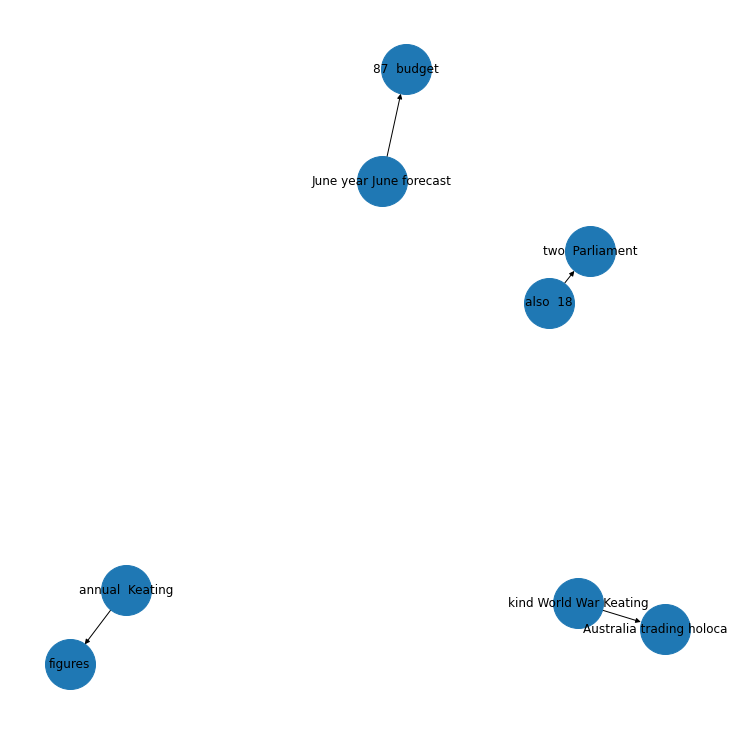

In [93]:
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

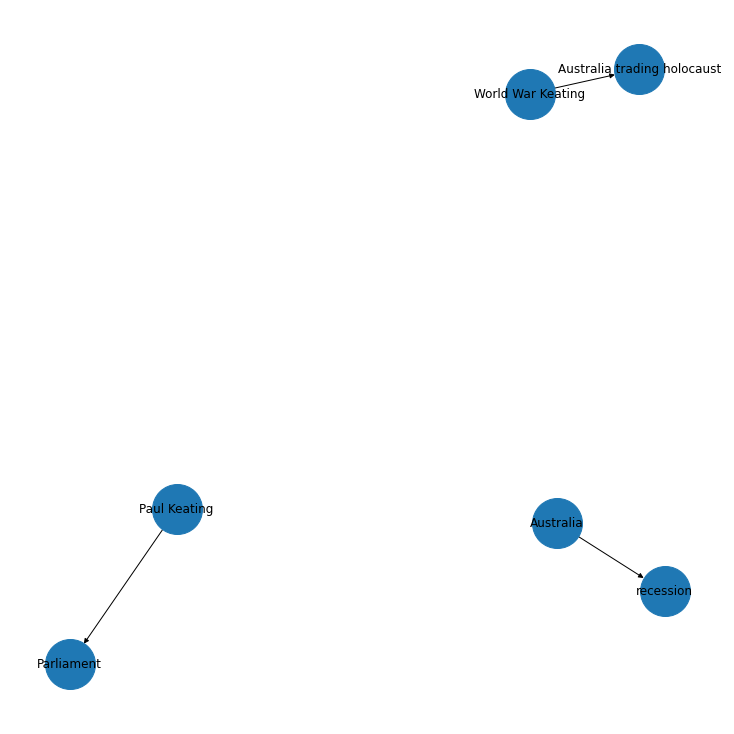

In [ ]:
G = nx.from_pandas_edgelist(knowledge_graph_df,source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

**References**
1. https://becominghuman.ai/building-a-small-knowledge-graph-using-ner-296930592bcf
2. https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/